In [2]:
import torchinfo
import torch
from jetnet_dataloader import JetNetDataloader
from lit_nf import TransGan
from plotting import *
import pandas as pd
from jetnet.evaluation import w1p, w1efp, w1m, cov_mmd,fpnd
from jetnet.datasets import JetNet
from main import train
pd.set_option("display.max_colwidth",200)
import matplotlib.pyplot as plt
import os
import hist
import mplhep as hep
import torch
import numpy as np
import hist
from hist import Hist
import traceback
from helpers import mass
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
class plotting_paper():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,true,gen,config,step,p,model=None,logger=None,weight=1):
        self.config=model.config
        self.n_dim=self.config["n_dim"]
        self.gen=gen
        self.test_set=true
        self.step=step
        self.model=model
        self.p=p

        self.weight=weight
        if logger is not None:
            self.summary=logger
    def plot_mass_only(self,m,m_t,bins=15):
        fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(6,8))
        a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
        b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
        a=np.quantile(m_t,0.001)
        b=np.quantile(m_t,0.999)
        h=hist.Hist(hist.axis.Regular(bins,a,b))
        h2=hist.Hist(hist.axis.Regular(bins,a,b))
        bins = h.axes[0].edges
        h.fill(m)#,weight=1/self.weight)
        h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )

        main_ax_artists, sublot_ax_arists = h.plot_ratio(
            h2,
            ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
            rp_ylabel=r"Ratio",
            rp_num_label="Flow Generated",
            rp_denom_label="MC Simulatied",
            rp_uncert_draw_type="line",  # line or bar
        )
        ax[0].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

        ax[1].set_ylim(0.25,2)
        ax[0].set_xlim(a,b)
        ax[1].set_xlabel("$m_T$",fontweight="bold")
        ax[1].set_xlim(a,b)
        ax[0].set_ylabel("Counts",fontweight="bold" )
        ax[1].set_ylabel("Ratio",fontweight="bold")
  
     
#             print("added figure")
#             self.summary.close()

        plt.savefig("{}_mass".format(self.p))
        plt.show()

    def plot_marginals(self,ith=None,save=False,title=None):
        #This plots the marginal distribution for simulation and generation
        #Note that this is the data the model sees during training as input to model in the NF
        #This is the distribution of one of [eta,phi,pt] of one particle of the n particles per jet: for example the pt of the 3rd particle
        #if save, the histograms are logged to tensorboard otherwise they are shown
        
        plt.switch_backend('agg')
        name,label=["eta","phi","pt"],['${\eta}^{rel}_{7}$',"${\phi}^{rel}_{7}$","${p_T}^{rel}_{7}$"]
        fig,ax=plt.subplots(2,3,gridspec_kw={'height_ratios': [3, 1]},figsize=(18,6))
        particles=range(self.n_dim) if not ith else [3*ith,3*ith+1,3*ith+2]
        plt.suptitle(title,fontweight="bold")
        k=0
        for i in particles:
            if ith:
                ax_temp=ax[:,k]
            else:
                fig,ax_temp=plt.subplots(2,1)
            a=np.quantile(self.test_set[:,i].numpy(),0)
            b=np.quantile(self.test_set[:,i].numpy(),1)

            h=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h2=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h.fill(self.gen[:,i].numpy())
            h2.fill(self.test_set[:,i].numpy())
            
            plt.tight_layout()
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0,k] )
       
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax_temp[0],"ratio_ax":ax_temp[1]},
                rp_ylabel=r"Ratio",
#                 rp_xlabel=label[i%3],
                rp_num_label="Flow Generated",
                rp_denom_label="MC Simulated",
                rp_uncert_draw_type="line",  # line or bar
            )
            
            
            ax_temp[0].set_xlabel("")
            ax_temp[1].set_ylim(0.25,2)
            ax_temp[0].set_xlim(a,b)
            ax_temp[1].set_xlim(a,b)
            ax_temp[1].set_xlabel(label[i%3])
            ax_temp[0].set_ylabel("Counts",fontweight="bold" )
            ax_temp[1].set_ylabel("Ratio",fontweight="bold")
            
            
            #plt.tight_layout(pad=2)
            k+=1
        if save:
            self.summary.add_figure("jet{}_{}".format(i//3+1,name[i%3]),fig,global_step=self.step)
            self.summary.close()
        else:
            plt.savefig("{}_7thpart".format(self.p))
            plt.show()


    def plot_2d(self,save=False):
        #This creates a 2D histogram of the inclusive distribution for all 3 feature combinations
        #Inclusive means that is the distribution of pt of all particles per jet and sample
        #if save, the histograms are logged to tensorboard otherwise they are shown
        data=self.test_set[:,:self.n_dim].reshape(-1,3).numpy()
        gen=self.gen[:,:self.n_dim].reshape(-1,3).numpy()
        labels=[r"$\eta^{rel}$",r"$\phi^{rel}_7$",r"$p_T^{rel}$"]
        names=["eta","phi","pt"]
        for index in [[0,1],[0,2],[1,2]]:
            
            fig,ax=plt.subplots(ncols=2,figsize=(16, 8))
            _,x,y,_=ax[0].hist2d(data[:,index[0]],data[:,index[1]],bins=30)
            #rebin to only take 5% to 95.0% of signal dis
            a=np.quantile(x,0.05)
            b=np.quantile(x,0.95)
            x=np.linspace(a,b,len(x))
            a=np.quantile(y,0.05)
            b=np.quantile(y,0.95)
            y=np.linspace(a,b,len(y))
            if index[1]==2:
                y=np.abs(y)+0.00001
                y = np.logspace(np.log(y[0]),np.log(y[-1]),len(y))
            ax[0].hist2d(data[:,index[0]],data[:,index[1]],bins=[x,y])
            data[:,index[0]]=np.abs(data[:,index[0]])+0.00001
            ax[1].hist2d(gen[:,index[0]],gen[:,index[1]],bins=[x,y])
        
        
            plt.tight_layout(pad=2)
            ax[0].set_xlabel( labels[index[0]],fontweight="bold")
            ax[0].set_ylabel( labels[index[1]],fontweight="bold")
            
            ax[0].set_title("MC Simulated")
            ax[1].set_xlabel( labels[index[0]],fontweight="bold")
            ax[1].set_ylabel( labels[index[1]],fontweight="bold")
            
            ax[1].set_title("Flow Generated")
           
            if save:
                self.summary.add_figure("2d{}-{}".format(names[index[0]],names[index[1]]),fig,global_step=self.step)
                
                # self.summary.close()
            else:
                plt.savefig("{}_2dcorr{}{}".format(self.p,names[index[0]],names[index[0]]))
                plt.show()
                
 
        
    def oversample(self,m,m_t,weight,save=False,quantile=False,bins=15,plot_vline=False,title=""):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(20,5))
        plt.suptitle(title,fontweight="bold")
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i],weight=1/weight)
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                bins = h.axes[0].edges
                h.fill(m,weight=1/weight)#,weight=1/self.weight)
                h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            try:
                main_ax_artists, sublot_ax_arists = h.plot_ratio(
                    h2,
                    ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                    rp_ylabel=r"Ratio",
                    rp_num_label="Flow Generated",
                    rp_denom_label="MC Simulatied",
                    rp_uncert_draw_type="line",  # line or bar
                )
                ax[0,k].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')
                    
                ax[1,k].set_ylim(0.25,2)
                ax[0,k].set_xlim(a,b)
                ax[1,k].set_xlabel(name,fontweight="bold")
                ax[1,k].set_xlim(a,b)
                ax[0,k].set_ylabel("Counts",fontweight="bold" )
                ax[1,k].set_ylabel("Ratio",fontweight="bold")
                
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
            except:
                print("mass plot failed reverting to simple plot mass bins")
                plt.close()
                plt.figure()
                _,b,_=plt.hist(m_t,15,label="MC Simulated",alpha=0.5)
                plt.hist(m,b,label="Flow Generated",alpha=0.5)
                plt.legend()  
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
            plt.tight_layout(pad=1)
            k+=1
        if save:
            if v!="m":
                 self.summary.add_figure("inclusive"+v,fig,self.step)
            else:
                self.summary.add_figure("jet_mass",fig,self.step)
#             print("added figure")
#             self.summary.close()
        else:
            plt.savefig("{}_oversample_{}".format(self.p,v))
            plt.show()

            
    def plot_mass(self,m,m_t,save=False,quantile=False,bins=15,plot_vline=False,title=""):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(24,6))
        plt.suptitle(title,fontweight="bold")
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i])
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                bins = h.axes[0].edges
                h.fill(m)#,weight=1/self.weight)
                h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            try:
                main_ax_artists, sublot_ax_arists = h.plot_ratio(
                    h2,
                    ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                    rp_ylabel=r"Ratio",
                    rp_num_label="Flow Generated",
                    rp_denom_label="MC Simulatied",
                    rp_uncert_draw_type="line",  # line or bar
                )
                ax[0,k].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')
                    
                ax[1,k].set_ylim(0.25,2)
                ax[0,k].set_xlim(a,b)
                ax[1,k].set_xlabel(name,fontweight="bold")
                ax[1,k].set_xlim(a,b)
                ax[0,k].set_ylabel("Counts",fontweight="bold" )
                ax[1,k].set_ylabel("Ratio",fontweight="bold")
                ax[0,k].legend(loc="upper left")  
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
            except:
                print("mass plot failed reverting to simple plot mass bins")
                plt.close()
                plt.figure()
                _,b,_=plt.hist(m_t,15,label="MC Simulated",alpha=0.5)
                plt.hist(m,b,label="Flow Generated",alpha=0.5)
                plt.legend(loc="upper left")  
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
            plt.tight_layout(pad=1)
            

            k+=1
        if save:
            if v!="m":
                 self.summary.add_figure("inclusive"+v,fig,self.step)
            else:
                self.summary.add_figure("jet_mass",fig,self.step)
#             print("added figure")
#             self.summary.close()
        else:
            plt.savefig("{}_inclusive_{}".format(self.p,v))
            plt.show()


    def losses(self,save=False):
        '''This plots the different losses vs epochs'''
        fig=plt.figure()
        hep.cms.label("Private Work",data=None,lumi=None,year=None)
        plt.xlabel('step')
        plt.ylabel('loss')
        ln1=plt.plot(self.model.logprobs,label='log$(p_{gauss}(x_{data}))$')
        if "calc_massloss" in self.config.keys() and self.config["calc_massloss"]:
            plt.twinx()
            ln2=plt.plot(self.model.mlosses,label=r'mass mse $\times$ {}'.format(self.config["lambda"]),color='orange')
            plt.ylabel("MSE")
            plt.yscale("log")
            ln1+=ln2
        labs=[l.get_label() for l in ln1]
        plt.legend(ln1,labs)
        plt.tight_layout(pad=2)
        if save:
            self.summary.add_figure("losses",fig,self.step)
#             self.summary.close()
        else:
            plt.show()
   

    def plot_correlations(self,save=True):
        #Plots correlations between all particles for i=0 eta,i=1 phi,i=2 pt
        self.plot_corr(i=0,save=save)
        self.plot_corr(i=1,save=save)
        self.plot_corr(i=2,save=save)

    def plot_corr(self,i=0,names=["$\eta^{rel}$","$\phi^{rel}$","$p_T$"],save=True):
        if i==2:
            c=1
        else:
            c=1
        df_g=pd.DataFrame(self.gen.reshape(-1,90).detach().numpy()[:,range(i,90,3)])
        df_h=pd.DataFrame(self.test_set.reshape(-1,90).detach().numpy()[:,range(i,90,3)])
        fig,ax=plt.subplots(ncols=2,figsize=(20,10))
        corr_g = ax[0].matshow(df_g.corr())
        corr_g.set_clim(-c,c)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(corr_g,cax=cax)
        corr_h = ax[1].matshow(df_h.corr())
        corr_h.set_clim(-c,c)
        divider = make_axes_locatable(ax[1])
        cax2 = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(corr_h,cax=cax2)
        plt.suptitle("{} Correlation between Particles".format(names[i]),fontweight="bold")
        ax[0].set_title("Flow Generated",fontweight="bold")
        ax[1].set_title("MC Simulated",fontweight="bold")
        ax[0].set_xlabel("Particles",fontweight="bold")
        ax[0].set_ylabel("Particles",fontweight="bold")
        ax[1].set_xlabel("Particles",fontweight="bold")
        ax[1].set_ylabel("Particles",fontweight="bold")
        title=["corr_eta","corr_phi","corr_pt"]
        if save:
                
                self.summary.add_figure(title[i],fig,self.step)    
    #             self.summary.close()
        else:
                plt.savefig("{}_{}".format(self.p,title[i]))
                plt.show()

    def var_part(self,true,gen,true_n,gen_n,m_true,m_gen,form=2,save=True):
        labels=["$\eta^{rel}$","$\phi^{rel}$","$p^{rel}_T$","$m^{rel}$"]
        names=["eta","phi","pt","m"]
        n,counts=torch.unique(true_n,return_counts=True)
        for j in range(4):
            fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,15))

            k=-1
            ntemp=n[-form**2:]

            
            for i in list(ntemp)[::-1]: 
                k+=1
                i=int(i)

                if names[j]!="m":
                    a=np.quantile(self.test_set[true_n.reshape(-1)==i,:].reshape(-1,3)[:,j],0.001)
                    b=np.quantile(self.test_set[true_n.reshape(-1)==i,:].reshape(-1,3)[:,j],0.999)    
                    h=hist.Hist(hist.axis.Regular(15,a,b))
                    h2=hist.Hist(hist.axis.Regular(15,a,b))
                    bins = h.axes[0].edges

                    ax[k//form,k%form].legend()
                    h.fill(self.gen[gen_n.reshape(-1)==i,:].reshape(-1,3)[:,j])
                    h2.fill(self.test_set[true_n.reshape(-1)==i,:].reshape(-1,3)[:,j])
                    
                else:
                    a=np.quantile(m_true[true_n.reshape(-1)==i],0.001)
                    b=np.quantile(m_gen[gen_n.reshape(-1)==i],0.999)
  
                    h=hist.Hist(hist.axis.Regular(15,a,b,label=labels[j]))
                    h2=hist.Hist(hist.axis.Regular(15,a,b,label=labels[j]))
                    bins = h.axes[0].edges
                    h.fill(m_gen[gen_n.reshape(-1)==i])
                    h2.fill(m_true[true_n.reshape(-1)==i])
                    

                h.plot1d(    ax=ax[k//2,k%2],label="Flow Simulated")  # line or bar)
                h2.plot1d(    ax=ax[k//2,k%2],label="MC Generated")  # line or bar)
                ax[k//2,k%2].set_title("{} Distribution for jets with {} particles".format(labels[j],i))

                ax[k//2,k%2].set_xlabel(labels[j])
                ax[k//2,k%2].set_ylabel("Counts",fontweight="bold")
                ax[k//2,k%2].set_xlim(a,b)
                ax[k//2,k%2].legend()
                #plt.tight_layout(pad=2)

            if save:
                self.summary.add_figure("jet{}_{}".format(i//3+1,names[i%3]),fig,global_step=self.step)
                self.summary.close()
            else:
                plt.savefig("jet{}_{}".format(self.p,i//3+1,names[j]))
                plt.show()

(array([2.585348e+06, 6.648210e+05, 2.325090e+05, 1.081130e+05,
        5.724600e+04, 3.240000e+04, 2.002200e+04, 1.222400e+04,
        6.959000e+03, 5.170000e+03, 3.572000e+03, 2.453000e+03,
        1.692000e+03, 1.282000e+03, 8.630000e+02, 6.010000e+02,
        4.640000e+02, 3.590000e+02, 2.150000e+02, 1.650000e+02,
        1.340000e+02, 7.800000e+01, 4.400000e+01, 3.800000e+01,
        3.300000e+01, 1.000000e+01, 4.000000e+00, 6.000000e+00,
        1.000000e+00, 4.000000e+00]),
 array([0.        , 0.02850437, 0.05700875, 0.08551312, 0.11401749,
        0.14252187, 0.17102624, 0.19953062, 0.22803499, 0.25653937,
        0.28504375, 0.31354812, 0.3420525 , 0.37055686, 0.39906123,
        0.4275656 , 0.45606998, 0.48457435, 0.51307875, 0.5415831 ,
        0.5700875 , 0.59859186, 0.62709624, 0.6556006 , 0.684105  ,
        0.71260935, 0.7411137 , 0.7696181 , 0.79812247, 0.82662684,
        0.8551312 ], dtype=float32),
 <BarContainer object of 30 artists>)

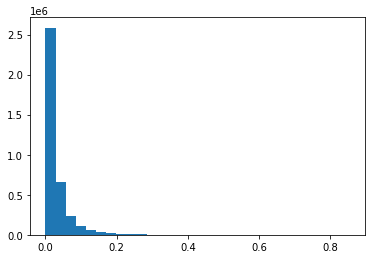

In [19]:
import matplotlib.pyplot as plt
plt.hist(df.data.reshape(-1,4).numpy()[:,2],bins=30)

In [22]:
import jetnet
df=jetnet.datasets.JetNet("t",normalize=False)
df.data.shape

torch.Size([124561, 30, 4])

In [3]:
import yaml
import os
best_hparam="/beegfs/desy/user/kaechben/Transflow_best/lightning_logs/version_72/hparams.yaml"
best_hparam="/beegfs/desy/user/kaechben/Transflow_best/lightning_logs/version_136/hparams.yaml"

with open(best_hparam, 'r') as stream:
        config=yaml.load(stream,Loader=yaml.Loader)
        print(config)
        config=config["config"]
data_module = JetNetDataloader(config,) #this loads the data
data_module.setup("train")
# data=data_module.scaler.inverse_transform(data_module.data[:,:90]).reshape(-1,30,3)
model = TransGan(config,data_module.num_batches)

{'config': {'autoreg': False, 'context_features': 0, 'network_layers': 3, 'network_layers_nf': 2, 'network_nodes_nf': 256, 'batch_size': 1024, 'coupling_layers': 15, 'lr': 0.001, 'batchnorm': False, 'bins': 5, 'tail_bound': 6, 'limit': 150000, 'n_dim': 3, 'dropout': 0.2, 'canonical': False, 'max_steps': 100000, 'lambda': 1, 'name': 'Transflow_best', 'disc': False, 'variable': 1, 'parton': 't', 'wgan': False, 'corr': True, 'num_layers': 4, 'freq': 6, 'n_part': 30, 'fc': False, 'hidden': 500, 'heads': 4, 'l_dim': 100, 'lr_g': 0.0004327405312571664, 'lr_d': 0.0004327405312571664, 'lr_nf': 0.000722, 'sched': 'cosine2', 'opt': 'RMSprop', 'max_epochs': 3200, 'mass': True, 'no_hidden': False, 'clf': True, 'val_check': 50, 'frac_pretrain': 80, 'seed': 69, 'quantile': False}, 'num_batches': 112}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/kaechben/JetNet_NF/LitJetNet/LitNF/lit_nf.py:270: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(p)


In [19]:

best_model="/beegfs/desy/user/kaechben/Transflow_best/epoch=1749-val_fpnd=0.08-val_w1m=0.0008.ckpt"
best_model="/beegfs/desy/user/kaechben/Transflow_best/epoch=2399-val_fpnd=0.16-val_w1m=0.0007.ckpt"
batch=data_module.test_set
mask = batch[:, 90:].cpu().bool()
batch = batch[:, :90].cpu()

model=model.load_from_checkpoint(best_model)
model.load_datamodule(data_module)

mask_test = model.sample_n(mask).bool()
# mask_test=mask

model.flow.train()
model.dis_net.train()
model.gen_net.train()
model.data_module.scaler.to("cpu")
batch = batch.to("cpu")
model.flow = model.flow.to("cpu")
model.dis_net = model.dis_net.cpu()
model.gen_net = model.gen_net.cpu()
with torch.no_grad():
#for some wierd reason its better with mask==None???
    gen, true, z, fake_scaled, true_scaled, z_scaled = model.sampleandscale(batch, mask=mask_test,scale=True)
    fake_scaled=fake_scaled*(~mask_test).reshape(-1,30,1)
    true_scaled=true_scaled*mask.reshape(-1,30,1)
    if model.config["mass"]:
        m_t = mass(batch.reshape(len(batch), model.n_part * model.n_dim), model.config["canonical"])
        m_f = mass(gen.reshape(len(batch), model.n_part * model.n_dim), model.config["canonical"])

    
    # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
    
    true_scaled, fake_scaled, z_scaled = (true_scaled.reshape(-1, 90), fake_scaled.reshape(-1, 90), z_scaled.reshape(-1, 90))
    for i in range(30):
        i = 2 + 3 * i
        z_scaled[z_scaled[:,i]<0,i]=0
        fake_scaled[fake_scaled[:, i] < 0, i] = 0
        true_scaled[true_scaled[:, i] < 0, i] = 0
    # Some metrics we track
    cov, mmd = cov_mmd(fake_scaled.reshape(-1, model.n_part, model.n_dim), true_scaled.reshape(-1, model.n_part, model.n_dim), use_tqdm=False)
    try:
        fpndv = fpnd(fake_scaled.reshape(-1, model.n_part, model.n_dim).numpy(), use_tqdm=False, jet_type=model.config["parton"])
        print(fpndv)
    except:
        fpndv = 1000
    w1m_ = w1m(fake_scaled.reshape(len(batch), model.n_part, model.n_dim), true_scaled.reshape(len(batch), model.n_part, model.n_dim))
    w1p_ = w1p(fake_scaled.reshape(len(batch), model.n_part, model.n_dim), true_scaled.reshape(len(batch), model.n_part, model.n_dim))
    w1efp_ = w1efp(fake_scaled.reshape(len(batch), model.n_part, model.n_dim), true_scaled.reshape(len(batch), model.n_part, model.n_dim))


   

0.1909634580456725


(array([  0.,   0.,   0.,   0.,   0., 679.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

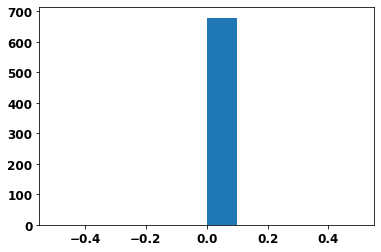

In [20]:
plt.hist(fake_scaled[mask_test[:,-1],-1].numpy())

In [21]:
w1m_,w1efp_,w1p_

((0.0010172608145598532, 0.00018236029401274206),
 (1.876128479017114e-05, 1.462494957788929e-05),
 (0.0009600672754827626, 0.000345264524786217))

# batch=torch.vstack((data_module.data[:,:90],batch))
mask=torch.vstack((data_module.data[:,90:].bool(),mask))

covz, mmdz = cov_mmd(z_scaled.reshape(-1, model.n_part, model.n_dim), true_scaled.reshape(-1, model.n_part, model.n_dim), use_tqdm=False)
try:
    fpndvz = fpnd(z_scaled.reshape(-1, model.n_part, model.n_dim).numpy(), use_tqdm=False, jet_type=model.config["parton"])
    print(fpndvz)
except:
    fpndv = 1000
w1m_z = w1m(z_scaled.reshape(len(batch), model.n_part, model.n_dim), true_scaled.reshape(len(batch), model.n_part, model.n_dim))
w1p_z = w1p(z_scaled.reshape(len(batch), model.n_part, model.n_dim), true_scaled.reshape(len(batch), model.n_part, model.n_dim))
w1efp_z = w1efp(z_scaled.reshape(len(batch), model.n_part, model.n_dim), true_scaled.reshape(len(batch), model.n_part, model.n_dim))


In [10]:
mask = batch[:, 90:].cpu()
batch = batch[:, :90].cpu()
mask_test=self.sample_n(mask)
batch = batch.to("cpu")
model.flow.train()
model.dis_net.train()
model.gen_net.train()
model.data_module.scaler.to("cpu")
batch = batch.to("cpu")
model.flow = model.flow.to("cpu")
model.dis_net = model.dis_net.cpu()
model.gen_net = model.gen_net.cpu()

with torch.no_grad():
    gen, true, z, fake_scaled, true_scaled, z_scaled = model.sampleandscale(batch, mask=mask_test,scale=True)
    if model.config["mass"]:
        m_t = mass(batch.reshape(len(batch), model.n_part * model.n_dim), model.config["canonical"])
        m_f = mass(gen.reshape(len(batch), model.n_part * model.n_dim), model.config["canonical"])

    
true_scaled, fake_scaled, z_scaled = (true_scaled.reshape(-1, 90), fake_scaled.reshape(-1, 90), z_scaled.reshape(-1, 90))
# Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
m_t = mass(
    true_scaled[:, : self.n_dim * self.n_part].to(self.device),
    self.config["canonical"],
).cpu()
m_gen = mass(z_scaled[:, : self.n_dim * self.n_part], self.config["canonical"]).cpu()
m_c = mass(fake_scaled[:, : self.n_dim * self.n_part], self.config["canonical"]).cpu()
for i in range(30):
    i = 2 + 3 * i
    # gen[gen[:,i]<0,i]=0
    fake_scaled[fake_scaled[:, i] < 0, i] = 0
    true_scaled[true_scaled[:, i] < 0, i] = 0
# Some metrics we track
cov, mmd = cov_mmd(fake_scaled.reshape(-1, self.n_part, self.n_dim), true_scaled.reshape(-1, self.n_part, self.n_dim), use_tqdm=False)
try:
    fpndv = fpnd(fake_scaled.reshape(-1, self.n_part, self.n_dim).numpy(), use_tqdm=False, jet_type=self.config["parton"])
except:
    fpndv = 1000
w1m_ = w1m(fake_scaled.reshape(len(batch), self.n_part, self.n_dim), true_scaled.reshape(len(batch), self.n_part, self.n_dim))[0]
w1p_ = w1p(fake_scaled.reshape(len(batch), self.n_part, self.n_dim), true_scaled.reshape(len(batch), self.n_part, self.n_dim))[0]
w1efp_ = w1efp(fake_scaled.reshape(len(batch), self.n_part, self.n_dim), true_scaled.reshape(len(batch), self.n_part, self.n_dim))[0]
self.metrics["val_fpnd"].append(fpndv)
self.metrics["val_logprob"].append(logprob)
self.metrics["val_mmd"].append(mmd)
self.metrics["val_cov"].append(cov)
self.metrics["val_w1p"].append(w1p_)
self.metrics["val_w1m"].append(w1m_)
self.metrics["val_w1efp"].append(w1efp_)

if (np.array([w1m_])[-4:] > 0.01).all() and self.current_epoch > 100 and not self.config["sched"] == "cosine2":
    print("no convergence, stop training")
    raise

temp = {
    "val_logprob": float(logprob.numpy()),
    "val_fpnd": fpndv,
    "val_mmd": mmd,
    "val_cov": cov,
    "val_w1m": w1m_,
    "val_w1efp": w1efp_,
    "val_w1p": w1p_,
    "step": self.global_step,
}
print("epoch {}: ".format(self.current_epoch), temp)
if self.hyperopt and self.global_step > 3:
    try:
        self._results(temp)
    except:
        print("error in results")
    summary = self._summary(temp)
self.log("hp_metric", self.metrics["val_w1m"][-1], on_step=False, on_epoch=True, prog_bar=True, logger=True)
self.log("val_w1m", self.metrics["val_w1m"][-1], on_step=False, on_epoch=True, prog_bar=True, logger=True)
self.log("val_w1p", self.metrics["val_w1p"][-1], on_step=False, on_epoch=True, prog_bar=True, logger=True)
self.log("val_w1efp", self.metrics["val_w1efp"][-1], on_step=False, on_epoch=True, prog_bar=True, logger=True)
self.log("val_logprob", logprob, prog_bar=True, logger=True)
self.log("val_cov", cov, prog_bar=True, logger=True, on_step=False, on_epoch=True)
self.log("val_fpnd", fpndv, prog_bar=True, logger=True, on_step=False, on_epoch=True)
self.log("val_mmd", mmd, prog_bar=True, logger=True, on_step=False, on_epoch=True)
self.plot = plotting(
    model=self,
    gen=z_scaled,
    gen_corr=fake_scaled,
    true=true_scaled,
    config=self.config,
    step=self.global_step,
    logger=self.logger.experiment,
)
try:
    self.plot.plot_mass(m=m_gen.cpu().numpy(), m_t=m_t.cpu().numpy(), m_c=m_c.cpu().numpy(), save=True, bins=50, quantile=True, plot_vline=False)
    # self.plot.plot_2d(save=True)
#             self.plot.var_part(true=true[:,:self.n_dim],gen=gen_corr[:,:self.n_dim],true_n=n_true,gen_n=n_gen_corr,m_true=m_t,m_gen=m_test ,save=True)
except Exception as e:
    traceback.print_exc()
self.flow = self.flow.to("cuda")
self.gen_net = self.gen_net.to("cuda")
self.dis_net = self.dis_net.to("cuda")


(0.0010335198270001698, 0.00021850261132931535)


In [16]:
file=torch.zeros((165000,30,4))
file[:,:,:3]=fake_scaled.reshape(-1,30,3)
file[:,:,3]=~mask_test
torch.save(file,"moritz.pt")

In [5]:
import time 
batch=data_module.test_set
model=model.load_from_checkpoint(best_model)
model.load_datamodule(data_module)
mask = batch[:, 90:].cpu().bool()
batch = batch[:, :90].cpu()
original_batch=batch
model.flow.train()
model.dis_net.train()
model.gen_net.train()
model.data_module.scaler.to("cuda")
batch = original_batch[:50000].to("cuda")
model.flow = model.flow.to("cuda")
model.dis_net = model.dis_net.cuda()
model.gen_net = model.gen_net.cuda()
start=time.time()

with torch.no_grad():
#for some wierd reason its better with mask==None???
    mask_test = model.sample_n(mask[:50000]).bool().cuda()
    gen, true, z, fake_scaled, true_scaled, z_scaled = model.sampleandscale(batch, mask=mask_test,scale=True)
print((time.time()-start)/50000)

8.586864471435547e-06


# Print table for paper


In [6]:
def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"

# print_table.index=["t"]#"q"
# print_table["model"]=["t"]#"q"
cols=["w1m_","w1p_","w1efp_","pmm","pmp","pme","cov","fpndv","mmd","model"]

print_table=pd.DataFrame([[w1m_z[0],w1p_z[0],w1efp_z[0],w1m_z[1],w1p_z[1]
                          ,w1efp_z[1],covz,fpndvz,mmdz,"VNF"],[w1m_[0],w1p_[0],w1efp_[0],w1m_[1],w1p_[1]
                          ,w1efp_[1],cov,fpndv,mmd,"TF",]],columns=cols).set_index("model",drop=False)


print_table.loc[:,"w1m_"]*=1000
print_table.loc[:,"w1p_"]*=1000
print_table.loc[:,"w1efp_"]*=100000
print_table.loc[:,"pmm"]*=1000
print_table.loc[:,"pmp"]*=1000
print_table.loc[:,"pme"]*=100000


print_table.loc["MP-MP-t",:]=np.array([0.6,2.3,2,.2,.3,1,0.57,0.37,0.071,"MP-MP"])
print_table.loc["MPLFC-MP-t",:]=np.array([0.9,2.2,2,.3,.7,1,0.56,0.93,0.073,"MP_LFC-MP"])
print_table.loc[:,"w1m_"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m_"]),float(x["pmm"])),axis=1)
print_table.loc[:,"w1efp_"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp_"]),float(x["pme"])),axis=1)
print_table.loc[:,"w1p_"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p_"]),float(x["pmp"])),axis=1)


print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"fpndv"]=print_table.loc[:,"fpndv"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)
print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
print_table.loc[:,"parton"]="t"
# print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
# print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
# print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
print_table.loc[:,"fpndv"]="$"+print_table["fpndv"].map(str)+"$"
print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"

# print_table.loc[:,"model"]=print_table["model"].str.replace("c0","VNF").str.replace("cc","NFCC").str.replace("c","NFC").str.replace("1","\ (m)").str.replace("2","\ (m,n)").str.replace("q","").str.replace("g","").str.replace("t","")
index=["MP-MP","MP_LFC-MP","VNF","TF"]#"MP-MP-q","MPLFC-MP-q","q"
print_table=print_table.set_index("model")
print_table["model"]=print_table.index
print(print_table)
print_table=print_table.loc[index,:]
final_table=pd.DataFrame()
tex=""
for p in ["t"]:#"q",
    temp=print_table[print_table["parton"]==p]

    for col in print_table.drop("model",1).columns:
        
        if col not in ["w1m_","w1p_","w1efp_","fpndv","cov","mmd" ]:
            continue
        
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["model","w1m_","w1p_","w1efp_","fpndv","cov","mmd"]]
    temp.columns=["model","$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{7}{*}{"+parton+"} & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
print(tex)

    #     final_table=final_table.append(temp)

# print(final_table.to_latex(index=False,escape=False))


                    w1m_           w1p_      w1efp_   pmm   pmp   pme     cov  \
model                                                                           
VNF        $4.8 \pm 0.2$  $2.5 \pm 0.3$  $13 \pm 1$  0.21  0.32  1.43  $0.56$   
TF         $2.6 \pm 0.1$  $4.3 \pm 0.4$  $12 \pm 1$  0.11  0.43  1.22  $0.49$   
MP-MP      $0.6 \pm 0.2$  $2.3 \pm 0.3$   $2 \pm 1$  0.20  0.30  1.00  $0.57$   
MP_LFC-MP  $0.9 \pm 0.3$  $2.2 \pm 0.7$   $2 \pm 1$  0.30  0.70  1.00  $0.56$   

            fpndv      mmd parton      model  
model                                         
VNF        $5.60$  $0.071$      t        VNF  
TF         $4.46$  $0.084$      t         TF  
MP-MP      $0.37$  $0.071$      t      MP-MP  
MP_LFC-MP  $0.93$  $0.073$      t  MP_LFC-MP  


/tmp/ipykernel_26200/200639810.py:74: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  for col in print_table.drop("model",1).columns:
/tmp/ipykernel_26200/200639810.py:79: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_26200/200639810.py:81: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"


\multirow{7}{*}{Top Quark} & 
MP-MP & $\mathbf{0.6 \pm 0.2}$ &$2.3 \pm 0.3$ &$\mathbf{2 \pm 1}$ & $\mathbf{0.37}$ & $\mathbf{0.57}$ & $\mathbf{0.071}$ \\&

MP\_LFC-MP &$0.9 \pm 0.3$ & $\mathbf{2.2 \pm 0.7}$ &$\mathbf{2 \pm 1}$ &$0.93$ &$0.56$ &$0.073$ \\&
VNF &$4.8 \pm 0.2$ &$2.5 \pm 0.3$ &$13 \pm 1$ &$5.60$ &$0.56$ & $\mathbf{0.071}$ \\&
 TF &$2.6 \pm 0.1$ &$4.3 \pm 0.4$ &$12 \pm 1$ &$4.46$ &$0.49$ &$0.084$ \\\cline{1-8}



/tmp/ipykernel_26200/200639810.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

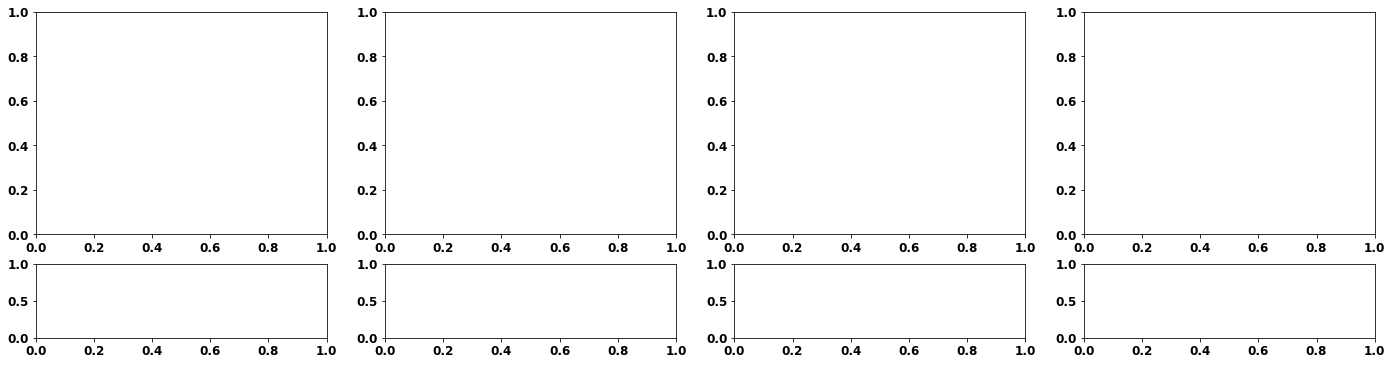

In [7]:
m_t = mass(
        true_scaled[:, : model.n_dim * model.n_part].to(model.device),
        model.config["canonical"],
    ).cpu()
m_gen = mass(z_scaled[:, : model.n_dim * model.n_part], model.config["canonical"]).cpu()
m_c = mass(fake_scaled[:, : model.n_dim * model.n_part], model.config["canonical"]).cpu()
plot=plotting_paper(true_scaled,fake_scaled,config,0,"t",model=model)
plot.plot_mass(m_c,m_t,save=False,quantile=False,bins=50,plot_vline=False,title="")


In [19]:
torch.triu(torch.ones(30,30))-torch.diag(torch.ones(30))

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.